In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()
import qiskit_nature
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.units import DistanceUnit
qiskit_nature.settings.use_pauli_sum_op = False
from qiskit_nature.second_q.drivers import PySCFDriver
import matplotlib.pyplot as plt
from qiskit.circuit.library import EfficientSU2
import numpy as np
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP,SPSA,NFT
from qiskit_aer.primitives import Estimator
#from qiskit.chemistry.drivers import PySCFDriver, UnitsType, Molecule
from qiskit.circuit.library import TwoLocal
import numpy as np


from qiskit import Aer
from qiskit.opflow import X, Z, I
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP,SPSA,NFT
from qiskit.circuit.library import TwoLocal

In [4]:
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeVigo

# fake providers contain data from real IBM Quantum devices stored in Qiskit,
# and are useful for extracting realistic noise models.
device = FakeVigo()

coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
seed = 170
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['id', 'sx', 'x', 'cx', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (3, 4)), ('cx', (4, 3)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (0, 1)), ('cx', (1, 0)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]


In [5]:
def get_qubit_op_jw(dist):
    # Define Molecule
    driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 "+str(dist),
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
    )
    # Get properties
    problem = driver.run()

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals
    
    mapper = ParityMapper()
    #tapered_mapper = problem.get_tapered_mapper(mapper)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

In [6]:
def exact_solver_jw(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result

In [7]:
distances = np.arange(0.1, 4.0, 0.1)
exact_energies_cobyla = []
vqe_energies_cobyla = []
error_cobyla = []
optimizer = COBYLA(maxiter=100)
#noiseless_estimator = Estimator(approximation=True)
noisy_estimator = Estimator(
    backend_options={
        "method": "density_matrix",
        "coupling_map": coupling_map,
        "noise_model": noise_model,
    },
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed},
)
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op_jw(
        dist
    )

    result = exact_solver_jw(qubit_op, problem)
    exact_energies_cobyla.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    vqe = VQE(
        noisy_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
    )
    
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies_cobyla.append(vqe_result)
    error_cobyla.append(abs(vqe_result - (-1.13619)))
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies_cobyla[-1]:.5f}",)

print("All energies have been calculated")

Interatomic Distance: 0.1 VQE Result: 3.63404 Exact Energy: 2.70996
Interatomic Distance: 0.2 VQE Result: 1.00318 Exact Energy: 0.15748
Interatomic Distance: 0.3 VQE Result: 0.14145 Exact Energy: -0.60180
Interatomic Distance: 0.4 VQE Result: -0.27917 Exact Energy: -0.91415
Interatomic Distance: 0.5 VQE Result: -0.51086 Exact Energy: -1.05516
Interatomic Distance: 0.6 VQE Result: -0.64993 Exact Energy: -1.11629
Interatomic Distance: 0.7 VQE Result: -0.73410 Exact Energy: -1.13619
Interatomic Distance: 0.8 VQE Result: -0.78652 Exact Energy: -1.13415
Interatomic Distance: 0.9 VQE Result: -0.81379 Exact Energy: -1.12056
Interatomic Distance: 1.0 VQE Result: -0.83087 Exact Energy: -1.10115
Interatomic Distance: 1.1 VQE Result: -0.84042 Exact Energy: -1.07919
Interatomic Distance: 1.2 VQE Result: -0.80848 Exact Energy: -1.05674
Interatomic Distance: 1.3 VQE Result: -0.82880 Exact Energy: -1.03519
Interatomic Distance: 1.4 VQE Result: -0.82308 Exact Energy: -1.01547
Interatomic Distance: 1.5

In [8]:
distances = np.arange(0.1, 4.0, 0.1)
exact_energies_spsa = []
vqe_energies_spsa = []
error_spsa = []
optimizer = SPSA(maxiter=100)
#noiseless_estimator = Estimator(approximation=True)
noisy_estimator = Estimator(
    backend_options={
        "method": "density_matrix",
        "coupling_map": coupling_map,
        "noise_model": noise_model,
    },
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed},
)
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op_jw(
        dist
    )

    result = exact_solver_jw(qubit_op, problem)
    exact_energies_spsa.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    vqe = VQE(
        noisy_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
    )
    
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies_spsa.append(vqe_result)
    error_spsa.append(abs(vqe_result - (-1.13619)))
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies_spsa[-1]:.5f}",)

print("All energies have been calculated")

Interatomic Distance: 0.1 VQE Result: 3.67258 Exact Energy: 2.70996
Interatomic Distance: 0.2 VQE Result: 1.03761 Exact Energy: 0.15748
Interatomic Distance: 0.3 VQE Result: 0.61865 Exact Energy: -0.60180
Interatomic Distance: 0.4 VQE Result: -0.25321 Exact Energy: -0.91415
Interatomic Distance: 0.5 VQE Result: -0.50578 Exact Energy: -1.05516
Interatomic Distance: 0.6 VQE Result: -0.62411 Exact Energy: -1.11629
Interatomic Distance: 0.7 VQE Result: -0.71308 Exact Energy: -1.13619
Interatomic Distance: 0.8 VQE Result: -0.76466 Exact Energy: -1.13415
Interatomic Distance: 0.9 VQE Result: -0.78428 Exact Energy: -1.12056
Interatomic Distance: 1.0 VQE Result: -0.82679 Exact Energy: -1.10115
Interatomic Distance: 1.1 VQE Result: -0.83206 Exact Energy: -1.07919
Interatomic Distance: 1.2 VQE Result: -0.83341 Exact Energy: -1.05674
Interatomic Distance: 1.3 VQE Result: -0.83099 Exact Energy: -1.03519
Interatomic Distance: 1.4 VQE Result: -0.80400 Exact Energy: -1.01547
Interatomic Distance: 1.5

In [9]:
distances = np.arange(0.1, 4.0, 0.1)
exact_energies_slsqp = []
vqe_energies_slsqp = []
error_slsqp = []
optimizer = SLSQP(maxiter=100)
#noiseless_estimator = Estimator(approximation=True)
noisy_estimator = Estimator(
    backend_options={
        "method": "density_matrix",
        "coupling_map": coupling_map,
        "noise_model": noise_model,
    },
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed},
)
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op_jw(
        dist
    )

    result = exact_solver_jw(qubit_op, problem)
    exact_energies_slsqp.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    vqe = VQE(
        noisy_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
    )
    
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies_slsqp.append(vqe_result)
    error_slsqp.append(abs(vqe_result - (-1.13619)))
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies_slsqp[-1]:.5f}",)

print("All energies have been calculated")

Interatomic Distance: 0.1 VQE Result: 3.65657 Exact Energy: 2.70996
Interatomic Distance: 0.2 VQE Result: 1.02073 Exact Energy: 0.15748
Interatomic Distance: 0.3 VQE Result: 0.15645 Exact Energy: -0.60180
Interatomic Distance: 0.4 VQE Result: -0.25921 Exact Energy: -0.91415
Interatomic Distance: 0.5 VQE Result: -0.49123 Exact Energy: -1.05516
Interatomic Distance: 0.6 VQE Result: -0.62855 Exact Energy: -1.11629
Interatomic Distance: 0.7 VQE Result: -0.71062 Exact Energy: -1.13619
Interatomic Distance: 0.8 VQE Result: -0.75865 Exact Energy: -1.13415
Interatomic Distance: 0.9 VQE Result: -0.78526 Exact Energy: -1.12056
Interatomic Distance: 1.0 VQE Result: -0.79809 Exact Energy: -1.10115
Interatomic Distance: 1.1 VQE Result: -0.80180 Exact Energy: -1.07919
Interatomic Distance: 1.2 VQE Result: -0.79933 Exact Energy: -1.05674
Interatomic Distance: 1.3 VQE Result: -0.79266 Exact Energy: -1.03519
Interatomic Distance: 1.4 VQE Result: -0.78324 Exact Energy: -1.01547
Interatomic Distance: 1.5

In [10]:
distances = np.arange(0.1, 4.0, 0.1)
exact_energies_nft = []
vqe_energies_nft = []
error_nft = []
optimizer = NFT(maxiter=100)
#noiseless_estimator = Estimator(approximation=True)
noisy_estimator = Estimator(
    backend_options={
        "method": "density_matrix",
        "coupling_map": coupling_map,
        "noise_model": noise_model,
    },
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed},
)
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op_jw(
        dist
    )

    result = exact_solver_jw(qubit_op, problem)
    exact_energies_nft.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    vqe = VQE(
        noisy_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
    )
    
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies_nft.append(vqe_result)
    error_nft.append(abs(vqe_result - (-1.13619)))
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies_nft[-1]:.5f}",)

print("All energies have been calculated")

Interatomic Distance: 0.1 VQE Result: 3.65657 Exact Energy: 2.70996
Interatomic Distance: 0.2 VQE Result: 1.02073 Exact Energy: 0.15748
Interatomic Distance: 0.3 VQE Result: 0.15645 Exact Energy: -0.60180
Interatomic Distance: 0.4 VQE Result: -0.25921 Exact Energy: -0.91415
Interatomic Distance: 0.5 VQE Result: -0.49123 Exact Energy: -1.05516
Interatomic Distance: 0.6 VQE Result: -0.62855 Exact Energy: -1.11629
Interatomic Distance: 0.7 VQE Result: -0.71062 Exact Energy: -1.13619
Interatomic Distance: 0.8 VQE Result: -0.75865 Exact Energy: -1.13415
Interatomic Distance: 0.9 VQE Result: -0.78526 Exact Energy: -1.12056
Interatomic Distance: 1.0 VQE Result: -0.79809 Exact Energy: -1.10115
Interatomic Distance: 1.1 VQE Result: -0.81426 Exact Energy: -1.07919
Interatomic Distance: 1.2 VQE Result: -0.81223 Exact Energy: -1.05674
Interatomic Distance: 1.3 VQE Result: -0.80601 Exact Energy: -1.03519
Interatomic Distance: 1.4 VQE Result: -0.79702 Exact Energy: -1.01547
Interatomic Distance: 1.5

In [11]:
distances = np.arange(0.1, 4.0, 0.1)
exact_energies_bfgs = []
vqe_energies_bfgs = []
error_bfgs = []
optimizer = L_BFGS_B(maxiter=100)
#noiseless_estimator = Estimator(approximation=True)
noisy_estimator = Estimator(
    backend_options={
        "method": "density_matrix",
        "coupling_map": coupling_map,
        "noise_model": noise_model,
    },
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed},
)
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op_jw(
        dist
    )

    result = exact_solver_jw(qubit_op, problem)
    exact_energies_bfgs.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    vqe = VQE(
        noisy_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
    )
    
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies_bfgs.append(vqe_result)
    error_bfgs.append(abs(vqe_result - (-1.13619)))
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies_bfgs[-1]:.5f}",)

print("All energies have been calculated")

Interatomic Distance: 0.1 VQE Result: 3.65657 Exact Energy: 2.70996
Interatomic Distance: 0.2 VQE Result: 1.02073 Exact Energy: 0.15748
Interatomic Distance: 0.3 VQE Result: 0.15645 Exact Energy: -0.60180
Interatomic Distance: 0.4 VQE Result: -0.25921 Exact Energy: -0.91415
Interatomic Distance: 0.5 VQE Result: -0.49123 Exact Energy: -1.05516
Interatomic Distance: 0.6 VQE Result: -0.62855 Exact Energy: -1.11629
Interatomic Distance: 0.7 VQE Result: -0.71062 Exact Energy: -1.13619
Interatomic Distance: 0.8 VQE Result: -0.75865 Exact Energy: -1.13415
Interatomic Distance: 0.9 VQE Result: -0.78526 Exact Energy: -1.12056
Interatomic Distance: 1.0 VQE Result: -0.79809 Exact Energy: -1.10115
Interatomic Distance: 1.1 VQE Result: -0.80180 Exact Energy: -1.07919
Interatomic Distance: 1.2 VQE Result: -0.79933 Exact Energy: -1.05674
Interatomic Distance: 1.3 VQE Result: -0.79266 Exact Energy: -1.03519
Interatomic Distance: 1.4 VQE Result: -0.78324 Exact Energy: -1.01547
Interatomic Distance: 1.5

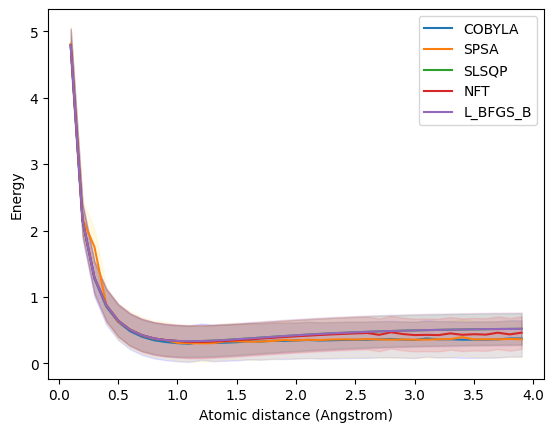

In [28]:
plt.plot(distances, error_cobyla, label="COBYLA")
ci = 0.2 * np.std(error_cobyla) / np.mean(error_cobyla)
plt.fill_between(distances, (error_cobyla-ci), (error_cobyla+ci), color='blue', alpha=0.1)

plt.plot(distances, error_spsa, label="SPSA")
ci_spsa = 0.2 * np.std(error_spsa) / np.mean(error_spsa)
plt.fill_between(distances, (error_spsa-ci_spsa), (error_spsa+ci_spsa), color='gold', alpha=0.1)

plt.plot(distances, error_slsqp, label="SLSQP")
ci_slsqp = 0.2 * np.std(error_slsqp) / np.mean(error_slsqp)
plt.fill_between(distances, (error_slsqp-ci_slsqp), (error_slsqp+ci_slsqp), color='green', alpha=0.1)

plt.plot(distances, error_nft, label="NFT")
ci_nft = 0.2 * np.std(error_nft) / np.mean(error_nft)
plt.fill_between(distances, (error_nft-ci_nft), (error_nft+ci_nft), color='red', alpha=0.1)

plt.plot(distances, error_bfgs, label="L_BFGS_B")
ci_bfgs = 0.2 * np.std(error_bfgs) / np.mean(error_bfgs)
plt.fill_between(distances, (error_bfgs-ci_nft), (error_bfgs+ci_nft), color='purple', alpha=0.1)

#plt.ylim(0,0.000000000001)
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.savefig("H2_Error_Optimizer_Comparison_Noisy.jpeg",dpi=300)
plt.show()


In [13]:
print(error_bfgs)

[4.792755325084995, 2.1569182884475584, 1.2926370383660606, 0.8769793021389545, 0.6449621771198857, 0.5076385138800934, 0.4255729977434397, 0.37754384896453974, 0.350933520351316, 0.33809772196595367, 0.3343874384061174, 0.33686223264698345, 0.3435278438160694, 0.35294831050219844, 0.3640611344060296, 0.3760787971646562, 0.38842389628841456, 0.40068078956024833, 0.4125587039498777, 0.4238634940938808, 0.43447548462617935, 0.44433140730940424, 0.45340932561463454, 0.4617161705832623, 0.46927785045237047, 0.4761318776209378, 0.4823222601337791, 0.4878962124648728, 0.49290215498986933, 0.4973885081616327, 0.5014029052925344, 0.5049915908305919, 0.5081988952679771, 0.5110667619885727, 0.5136343437962937, 0.5159376973949328, 0.5180095959992443, 0.51987946509106, 0.5215734317591582]


In [14]:
print(error_cobyla)

[4.770230640404947, 2.1393746214417937, 1.2776356885803823, 0.8570220063111791, 0.6253254824717371, 0.486256209380701, 0.4020875339294263, 0.34966552941186624, 0.32239521513425884, 0.3053211040728593, 0.2957702504312232, 0.3277114876487599, 0.30738985691135934, 0.3131128941109538, 0.3194335136194111, 0.3346917611561264, 0.32935865539685705, 0.3414568400848462, 0.33930260736689033, 0.34523927611802874, 0.35342100457718906, 0.34548282148138276, 0.348862765492838, 0.35343960814109365, 0.3556489711015961, 0.35673575336817764, 0.3628247782503886, 0.3669343095612949, 0.3590187049807382, 0.3534835051738692, 0.37580660534307586, 0.3624353327100919, 0.3639610102869215, 0.35720821775350964, 0.3582585259405041, 0.35803365472797943, 0.36245280142112923, 0.37651684227866056, 0.375751587907717]


In [15]:
print(error_slsqp)

[4.792755325084995, 2.1569182884475584, 1.2926370383660606, 0.8769793021389545, 0.6449621771198857, 0.5076385138800934, 0.4255729977434397, 0.37754384896453974, 0.350933520351316, 0.33809772196595367, 0.3343874384061174, 0.33686223264698345, 0.3435278438160694, 0.35294831050219844, 0.3640611344060296, 0.3760787971646562, 0.38842389628841456, 0.40068078956024833, 0.4125587039498777, 0.4238634940938808, 0.43447548462617935, 0.44433140730940424, 0.45340932561463454, 0.4617161705832623, 0.46927785045237047, 0.4761318776209378, 0.4823222601337791, 0.4878962124648728, 0.49290215498986933, 0.4973885081616327, 0.5014029052925344, 0.5049915908305919, 0.5081988952679771, 0.5110667619885727, 0.5136343437962937, 0.5159376973949328, 0.5180095959992443, 0.51987946509106, 0.5215734317591582]


In [17]:
print(error_spsa)

[4.808771186859325, 2.173796305648917, 1.754842645330695, 0.8829798080336382, 0.6304123460042983, 0.5120804309433213, 0.42311355579887855, 0.3715258128954033, 0.35190523919863104, 0.3094003343465811, 0.3041337109613962, 0.3027845623154015, 0.3052015289420311, 0.33218668292211095, 0.33240893633337465, 0.32842863452808424, 0.3290581761993019, 0.338473556754736, 0.3531236032242955, 0.3468043774997722, 0.35645290717973244, 0.35263479513865925, 0.3600381428415862, 0.36299474389125663, 0.3601333426275134, 0.365538441792318, 0.3615548738045511, 0.35681395405456773, 0.36197415470629357, 0.357140316926605, 0.3582444590307071, 0.3647524152771381, 0.36667755740820185, 0.3948642965169398, 0.3620189741367602, 0.3647696583813633, 0.36340952766963963, 0.36769889579265713, 0.36426616237989773]


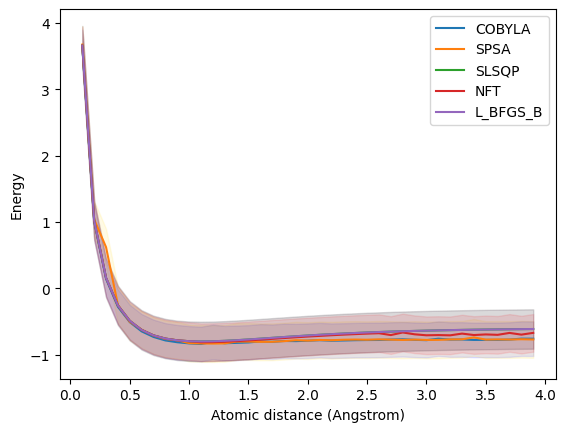

In [26]:
plt.plot(distances, vqe_energies_cobyla, label="COBYLA")
ci = 0.2 * np.std(vqe_energies_cobyla) / np.mean(vqe_energies_cobyla)
plt.fill_between(distances, (vqe_energies_cobyla-ci), (vqe_energies_cobyla+ci), color='blue', alpha=0.1)

plt.plot(distances, vqe_energies_spsa, label="SPSA")
ci = 0.2 * np.std(vqe_energies_spsa) / np.mean(vqe_energies_spsa)
plt.fill_between(distances, (vqe_energies_spsa-ci), (vqe_energies_spsa+ci), color='gold', alpha=0.1)

plt.plot(distances, vqe_energies_slsqp, label="SLSQP")
ci = 0.2 * np.std(vqe_energies_slsqp) / np.mean(vqe_energies_slsqp)
plt.fill_between(distances, (vqe_energies_slsqp-ci), (vqe_energies_slsqp+ci), color='green', alpha=0.1)

plt.plot(distances, vqe_energies_nft, label="NFT")
ci = 0.2 * np.std(vqe_energies_nft) / np.mean(vqe_energies_nft)
plt.fill_between(distances, (vqe_energies_nft-ci), (vqe_energies_nft+ci), color='red', alpha=0.1)

plt.plot(distances, vqe_energies_bfgs, label="L_BFGS_B")
ci = 0.2 * np.std(vqe_energies_bfgs) / np.mean(vqe_energies_bfgs)
plt.fill_between(distances, (vqe_energies_bfgs-ci), (vqe_energies_bfgs+ci), color='purple', alpha=0.1)
#plt.ylim(0,0.000000000001)
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.savefig("H2_Optimizer_Comparison_noisy.jpeg",dpi=300)
plt.show()